In [52]:
from Bio import SeqIO
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

def get_kmers(seq, K=30):
    start = 0
    end   = len(seq)
    kmers = list()
    ranges= list()
    for i in range(start, end):
        if i > len(seq)-K or ((i+K)>len(seq)):
            break
        else:
            kmers.append(seq[i:i+K])
            ranges.append(f"{i}_{i+K}")
    return kmers, ranges

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

In [53]:
dataset_name="disprot"
upix = 1
Ks = [30]
fastafile=None
fastadir="/data/franco/datasets/disprot/fasta/"
annotdir=None
annotfile="/data/franco/datasets/disprot/DisProt_release_2022_06_reformat_annot.fasta"


sequences = get_sequences(fastadir=fastadir, fastafile=fastafile)
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)

# find annotation for each sequence
# read annotation data first
annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[upix].strip()
    else:
        name = record.name.strip()
        if name == "":
            print("Name is empty",record.name)
            raise
    # if name != "A0A6L8PPD0":
    #     continue
    annot_dict[name] = str(record.seq)

In [54]:
selected_sequences = []
disseqs = list()
selected_uniprots = list()

for s in sequences:
    if "|" in s.name:
        name = s.name.split("|")[upix].strip()
    else:
        name = s.name.strip()
        if name == "":
            print("Name is empty",s.name)
            raise
    # print(f"Loading {name} data")
    aa_sequence = str(s.seq).upper()
    if len(aa_sequence) > 1200:
        print(f"Skipping {name}, len={len(aa_sequence)}")
        continue
    if len(s.seq) == len(annot_dict[name]):
            disseqs.append(annot_dict[name])
            selected_sequences.append(aa_sequence)
            selected_uniprots.append(name)
    else:
        print("Sequence and annotation length do not match")
        print(len(s.seq), len(annot_dict[name]), name)

Skipping Q9NRR4, len=1374
Skipping Q9C000, len=1473
Skipping P12296, len=2293
Skipping P49790, len=1475
Skipping Q03834, len=1242
Skipping P12823, len=3388
Skipping Q00955, len=2233
Skipping C4R4Y0, len=1743
Skipping Q96T58, len=3664
Skipping P70365, len=1447
Skipping O95405, len=1425
Skipping P08581, len=1390
Skipping P46674, len=1301
Skipping Q09427, len=1582
Skipping Q04637-8, len=1600
Skipping P08799, len=2116
Skipping Q00496, len=1251
Skipping P14340, len=3391
Skipping P03305, len=2332
Skipping Q9Q6P4, len=3433
Sequence and annotation length do not match
194 259 Q12983
Skipping D1A4G7, len=1315
Skipping Q7B8V4, len=1296
Skipping Q05022, len=1729
Skipping P29990, len=3391
Skipping A5YV76, len=2512
Skipping Q6A070, len=1776
Skipping P31327, len=1500
Skipping Q32ZE1, len=3419
Skipping P0DTD1, len=7096
Skipping P0C6X7, len=7073
Skipping O60706-2, len=1549
Skipping P15941, len=1255
Skipping P21333, len=2647
Skipping A7ZUK2, len=1407
Skipping Q09472, len=2414
Skipping P03316, len=1245
S

In [55]:
len(selected_uniprots)

2214

In [56]:
# generate kmer annotation file

Ks = [30]
for K in Ks:
    print(K)
    dataset_kmers_file = f"kmer_analysis_data/{dataset_name}_annot_kmers{K}.fasta"
    with open(dataset_kmers_file, 'w') as outstream:
        for i,s in enumerate(selected_sequences):
            uniprot_id = selected_uniprots[i]
            annotseq = annot_dict[uniprot_id]
            kmers, ranges = get_kmers(annotseq, K=K)
            for kmer, pos in zip(kmers, ranges):
                outstream.write(f">{uniprot_id}_{pos}\n")
                outstream.write(f"{kmer}\n")

30


In [57]:
fastafile = "kmer_analysis_data/disprot_kmers30.fasta"
fastadir = None

disprot_kmers = get_sequences(fastadir=fastadir, fastafile=fastafile)

fastafile = "kmer_analysis_data/disprot_annot_kmers30.fasta"
fastadir = None

disprot_annot_kmers = get_sequences(fastadir=fastadir, fastafile=fastafile)

In [58]:
kmer_dict = dict()
kmer_annot_dict = dict()
for r in disprot_kmers:
    kmer_dict[r.name] = str(r.seq)
    
for r in disprot_annot_kmers:
    kmer_annot_dict[r.name] = str(r.seq)

In [59]:
kmer_files = os.listdir("disprot_kmers30/halft5/")

In [61]:
print(len(kmer_files))
print(len(kmer_annot_dict.keys()))
print(len(kmer_dict.keys()))

839065
839065
839065


In [62]:
whole_kmer_embeddings = []
kmer_disorder_contents = []
for i,f in enumerate(kmer_files):
    emb = np.loadtxt(os.path.join("disprot_kmers30/halft5/", f))
    emb_mean = np.mean(emb, axis=0)
    kmerid = f.split(".")[0]
    # print(kmer_dict[kmerid]) # kmer sequence
    da = kmer_annot_dict[kmerid]
    contents = [ x != "-" for x in da]
    DC = np.sum(contents) / len(contents)
    kmer_disorder_contents.append(DC)
    whole_kmer_embeddings.append(emb_mean)
    if i%10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000


In [63]:
print(len(whole_kmer_embeddings))
print(len(kmer_disorder_contents))

839065
839065


In [68]:
[f"{e:.2f}" for e in kmer_disorder_contents[:100]]

['0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.50',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.47',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '0.37',
 '0.50',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.33',
 '0.27',
 '0.00',
 '0.00',
 '0.00',
 '0.23',
 '0.00',
 '0.00',
 '0.43',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '0.00',
 '1.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.67',
 '1.00',
 '0.00',
 '1.00',
 '0.17',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.07',
 '1.00',
 '1.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.27',
 '0.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.47',
 '1.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '1.00',
 '1.00',
 '1.00',
 '0.50',
 '0.00']

In [69]:
def list_saver(mylist, outfile):
    with open(outfile, 'w') as outfmt:
        for e in mylist:
            outfmt.write(e)
    return None

annot_out = "/data/franco/disorder_flavours/disprot_kmers30/kmer_disorder_contents.txt"
list_saver([f"{e:.2f}" for e in kmer_disorder_contents], annot_out)

In [65]:
print("Saving embedding data")
embedoutfile = "/data/franco/disorder_flavours/disprot_kmers30/kmer_level_embeddings.txt"
if not os.path.exists(embedoutfile):
    np.savez_compressed(embedoutfile, kmer_embeddings=np.array(whole_kmer_embeddings))


Saving embedding data


In [70]:
high_ix = np.array(kmer_disorder_contents) > 0.8
high_dc_kmers = np.array(whole_kmer_embeddings)[high_ix]

In [71]:
high_dc_kmers.shape

(140374, 1024)

In [72]:
import umap

myumap = umap.UMAP(n_neighbors=100, min_dist=0.2, densmap=True)
umap_coord = myumap.fit_transform(high_dc_kmers)

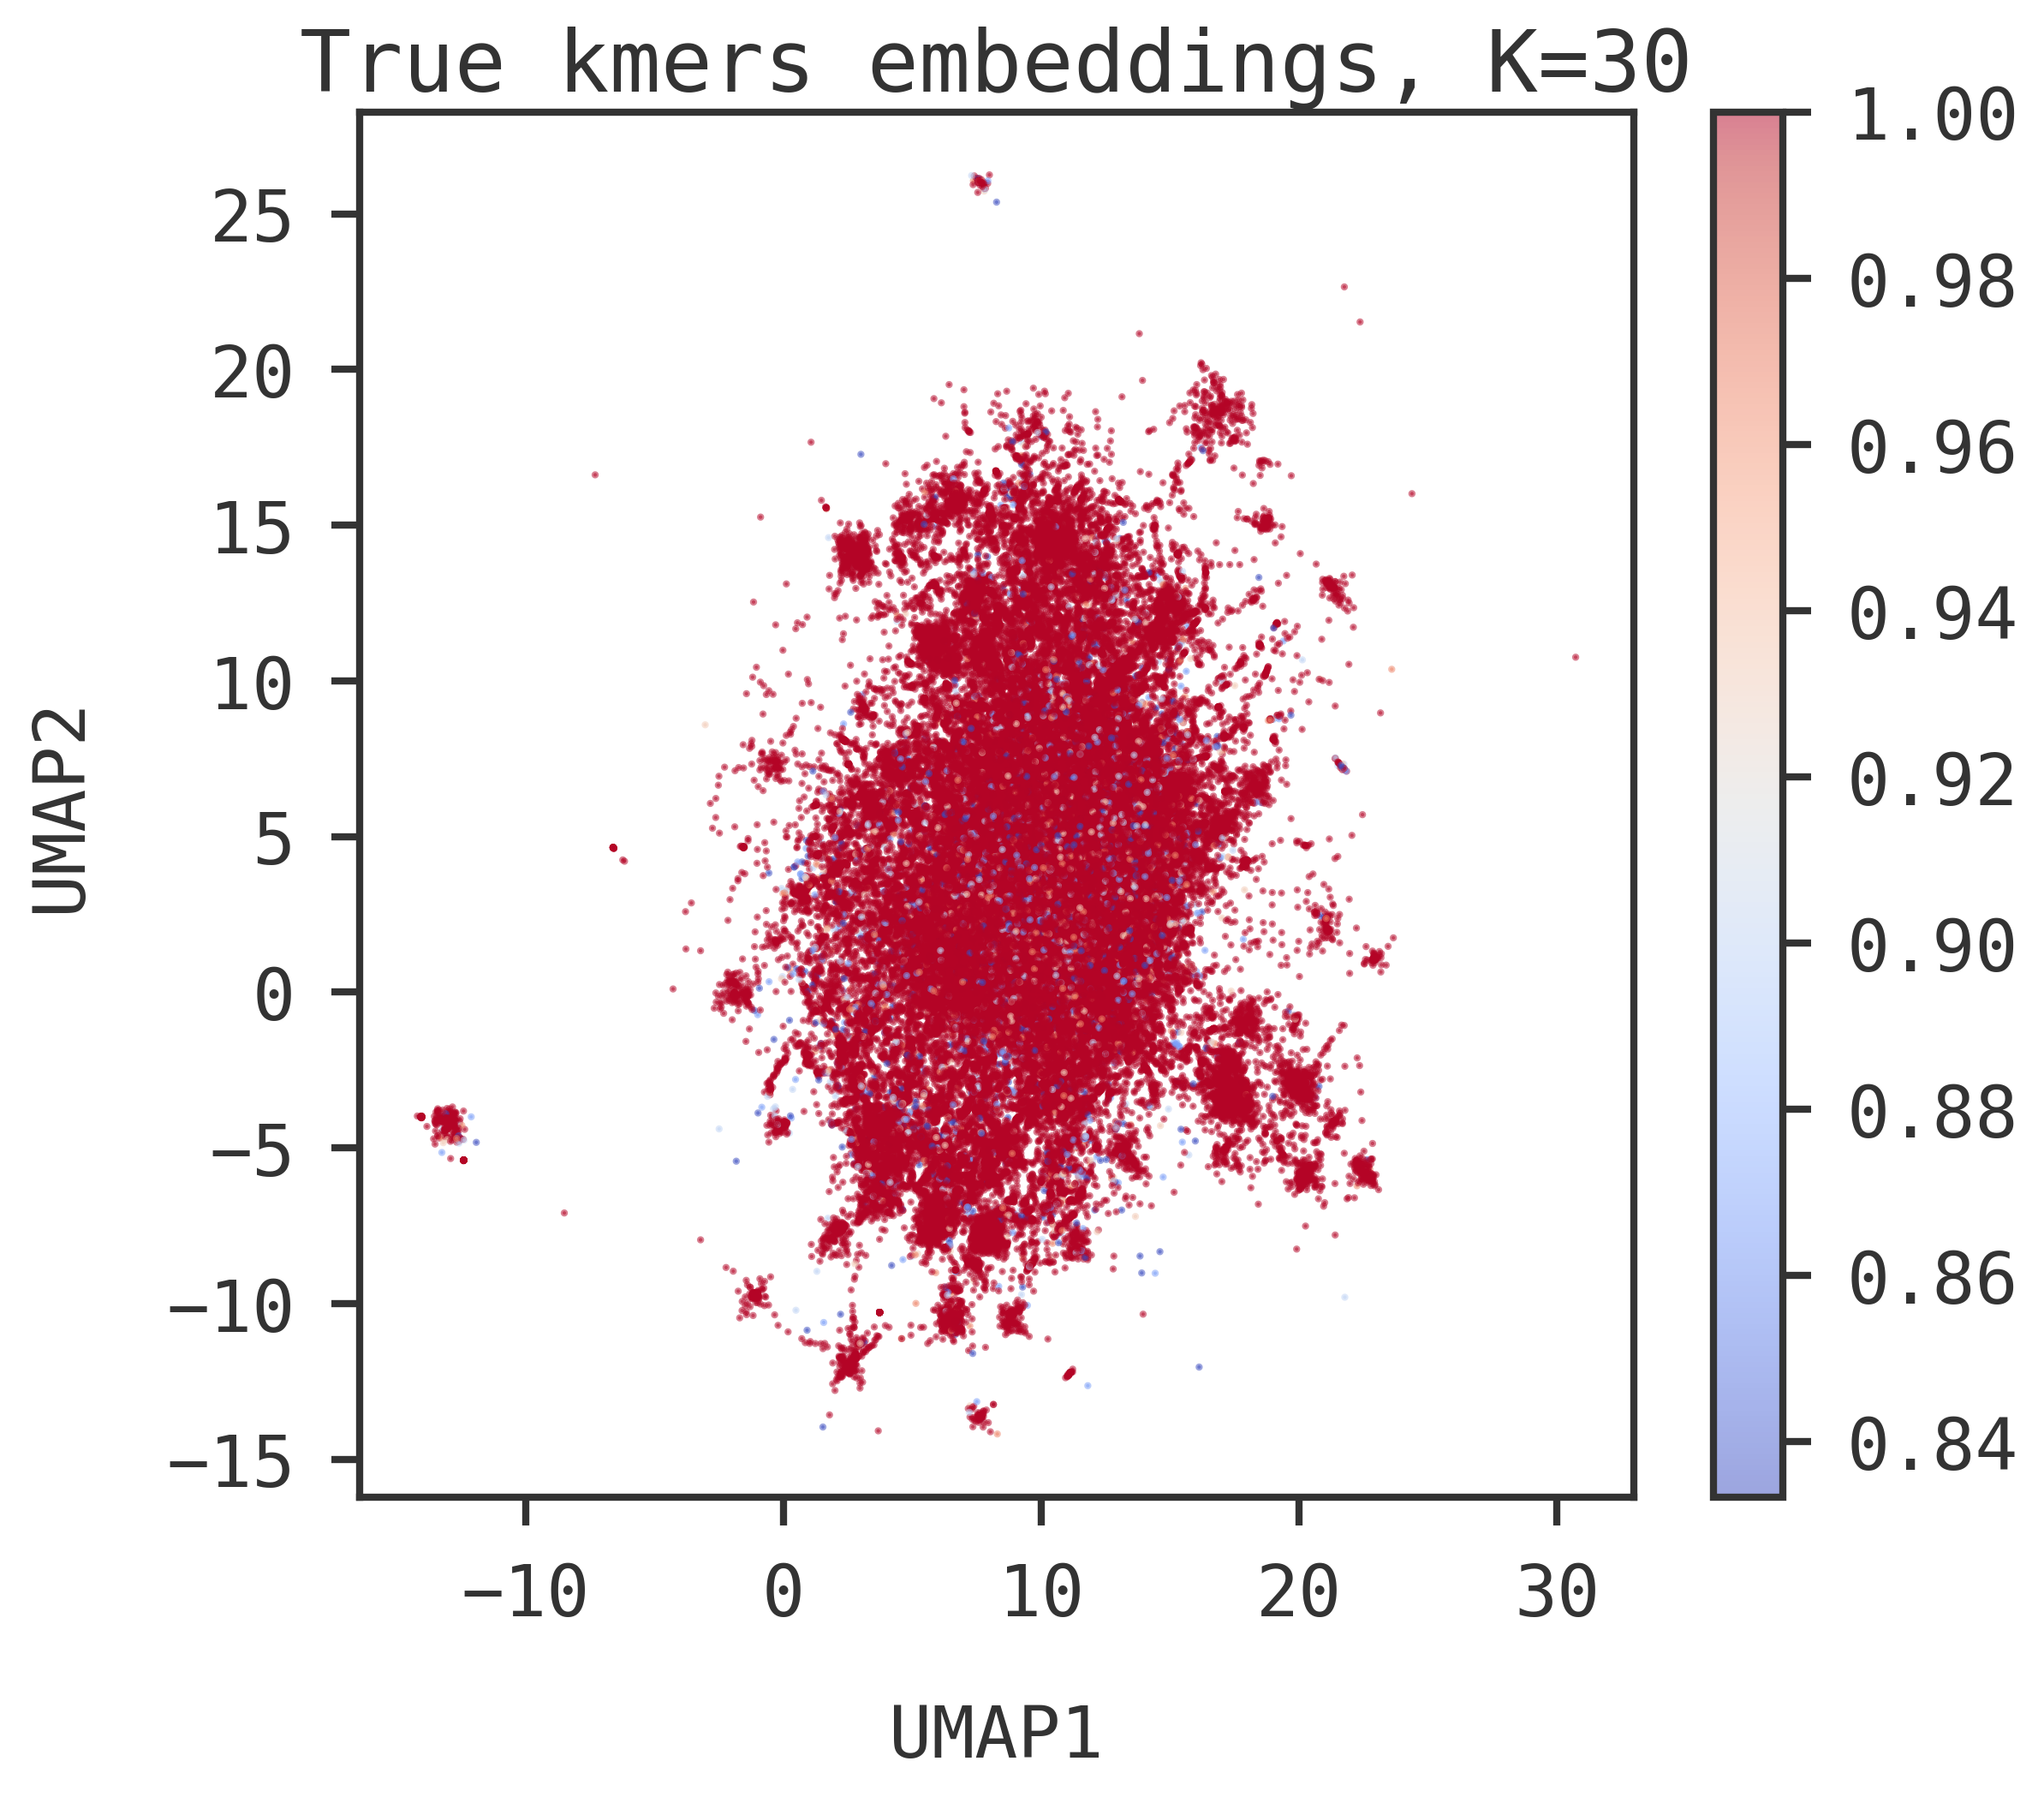

In [75]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(111)

colors = np.array(kmer_disorder_contents)[high_ix]

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_coord[:,0], umap_coord[:,1], s=1, c=colors, cmap=cmap, alpha=.5)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"True kmers embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
plt.savefig(f"high_disorder_embedded_kmers_k{K}_densUMAP.png", bbox_inches='tight')
plt.show()

In [76]:
myumap = umap.UMAP(n_neighbors=100, min_dist=0.2, densmap=False)
umap_coord_nodens = myumap.fit_transform(high_dc_kmers)

In [ ]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(111)

colors = np.array(kmer_disorder_contents)[high_ix]

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_coord_nodens[:,0], umap_coord_nodens[:,1], s=1, c=colors, cmap=cmap, alpha=.5)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"True kmers embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
plt.savefig(f"high_disorder_embedded_kmers_k{K}_UMAP.png", bbox_inches='tight')
plt.show()

In [82]:
myumap2     = umap.UMAP(n_neighbors=100, min_dist=0.2, densmap=True)
densumap_coord2 = myumap2.fit_transform(np.array(whole_kmer_embeddings))

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(densumap_coord2[:,0], densumap_coord2[:,1], s=1, c=kmer_disorder_contents, cmap=cmap, alpha=.2)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"True kmers embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
plt.savefig(f"embedded_kmers_k{K}_densUMAP.png", bbox_inches='tight')
plt.show()

In [ ]:
myumap2     = umap.UMAP(n_neighbors=100, min_dist=0.2, densmap=False)
umap_coord2 = myumap2.fit_transform(np.array(whole_kmer_embeddings))

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

cmap = plt.get_cmap("coolwarm")
sc = ax1.scatter(umap_coord2[:,0], umap_coord2[:,1], s=1, c=kmer_disorder_contents, cmap=cmap, alpha=.2)
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")
ax1.set_title(f"True kmers embeddings, K={K}")
plt.colorbar(sc, ax=ax1)
plt.savefig(f"embedded_kmers_k{K}_UMAP.png", bbox_inches='tight')
plt.show()